<a href="https://colab.research.google.com/github/neethu-vm/Deep-learning-neural-networks/blob/main/Copy_of_Food_Recognition_work.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# install dependencies: 
!pip install pyyaml==5.3
import torch, torchvision
print(torch.__version__, torch.cuda.is_available())
!gcc --version
# opencv is pre-installed on colab

     |████████████████████████████████| 276kB 8.5MB/s 
  Created wheel for pyyaml: filename=PyYAML-5.3-cp37-cp37m-linux_x86_64.whl size=44244 sha256=15d050827e4a9e54cf4a8d3e9d9790d719d0a997e6c94cffd6be24831bdc67bd
  Stored in directory: /root/.cache/pip/wheels/e4/76/4d/a95b8dd7b452b69e8ed4f68b69e1b55e12c9c9624dd962b191
Successfully built pyyaml
  Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
1.9.0+cu102 True
gcc (Ubuntu 7.5.0-3ubuntu1~18.04) 7.5.0
Copyright (C) 2017 Free Software Foundation, Inc.
This is free software; see the source for copying conditions.  There is NO
warranty; not even for MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.



In [ ]:
# Install torch 1.8.1.
# The Colab's default torch version is 1.9.0+cu102 which is not supported and tested by Detectron2 for now.
!pip install torch==1.8.1+cu102 torchvision==0.9.1+cu102 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 804.1MB 22kB/s 
     |████████████████████████████████| 17.3MB 162kB/s 
ERROR: torchtext 0.10.0 has requirement torch==1.9.0, but you'll have torch 1.8.1+cu102 which is incompatible.
  Found existing installation: torch 1.9.0+cu102
    Uninstalling torch-1.9.0+cu102:
      Successfully uninstalled torch-1.9.0+cu102
  Found existing installation: torchvision 0.10.0+cu102
    Uninstalling torchvision-0.10.0+cu102:
      Successfully uninstalled torchvision-0.10.0+cu102


In [ ]:
# install detectron2: (Colab has CUDA 10.2 + torch 1.9)
# See https://detectron2.readthedocs.io/tutorials/install.html for instructions
import torch
assert torch.__version__.startswith("1.8")   # need to manually install torch 1.8 if Colab changes its default version
!pip install detectron2 -f https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html
# exit(0)  # After installation, you need to "restart runtime" in Colab. This line can also restart runtime

Looking in links: https://dl.fbaipublicfiles.com/detectron2/wheels/cu102/torch1.8/index.html
     |████████████████████████████████| 6.2MB 3.4MB/s 
     |████████████████████████████████| 51kB 7.0MB/s 
     |████████████████████████████████| 81kB 11.0MB/s 
     |████████████████████████████████| 645kB 41.5MB/s 
     |████████████████████████████████| 112kB 55.9MB/s 
  Created wheel for fvcore: filename=fvcore-0.1.3.post20210317-cp37-none-any.whl size=58543 sha256=8951bbf7130a8c9a9b30de9170c9a4364f9a32be58013a8a4c800369828748e8
  Stored in directory: /root/.cache/pip/wheels/d2/ee/3a/5c531df777c03d8c67f22c65f97d6f75321087482d05a9b218
  Created wheel for antlr4-python3-runtime: filename=antlr4_python3_runtime-4.8-cp37-none-any.whl size=141231 sha256=9abffbd4690c6b50e881efa3124788d3916a7c48cfe411141f09386f02389cc1
  Stored in directory: /root/.cache/pip/wheels/e3/e2/fa/b78480b448b8579ddf393bebd3f47ee23aa84c89b6a78285c8
Successfully built fvcore antlr4-python3-runtime
  Found existing insta

In [ ]:
import detectron2
from detectron2.utils.logger import setup_logger
setup_logger()

# import some common libraries
import numpy as np
import os, json, cv2, random, glob

In [ ]:
# import some common detectron2 utilities
from detectron2 import model_zoo
from detectron2.engine import DefaultPredictor
from detectron2.config import get_cfg
from detectron2.utils.visualizer import Visualizer
from detectron2.data import MetadataCatalog, DatasetCatalog

In [ ]:

from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
import os

In [ ]:

from detectron2.structures import BoxMode
from detectron2.data import DatasetCatalog, MetadataCatalog

#mounting to drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


#Select food classes

In [ ]:
food_classes = ['dosa','egg curry','sambar','vellappam','rice','chappathi','chicken fry','maonize','chicken curry','cucumber','chutney','fish fry','kadala curry','veg curry','beef roast','pickle','pappadam','fish curry','cherupayar thoran','chai','egg','puttu','parippuvada','thoran','banana','cherupayar curry','tomato curry','carrot','chicken chilly','carrot thoran','idli','vada','vegcuury']
class_num = len(food_classes)
max_iter = 1000

#Registering the Data set

In [ ]:
def get_dataset_dicts(directory):
    classes = food_classes
    dataset_dicts = []
    for filename in [file for file in os.listdir(directory) if file.endswith('.json')]:
        json_file = os.path.join(directory, filename)
        with open(json_file) as f:
            img_anns = json.load(f)

        record = {}
        
        filename = os.path.join(directory, img_anns["imagePath"])
        
        record["file_name"] = filename
        record["height"] = img_anns['imageHeight']
        record["width"] = img_anns['imageWidth']

        print(record["height"], record["width"])
      
        annos = img_anns["shapes"]
        objs = []
        for anno in annos:
            px = [a[0] for a in anno['points']]
            py = [a[1] for a in anno['points']]
            poly = [(x, y) for x, y in zip(px, py)]
            poly = [p for x in poly for p in x]

            obj = {
                "bbox": [np.min(px), np.min(py), np.max(px), np.max(py)],
                "bbox_mode": BoxMode.XYXY_ABS,
                "segmentation": [poly],
                "category_id": classes.index(anno['label']),
                "iscrowd": 0
            }
            objs.append(obj)
        record["annotations"] = objs
        dataset_dicts.append(record)
    return dataset_dicts


In [ ]:
for d in ["train", "test"]:
    DatasetCatalog.register("class2_food_indian_" + d, lambda d=d: get_dataset_dicts('/content/drive/MyDrive/ashik/' + d))
    MetadataCatalog.get("class2_food_indian_" + d).set(thing_classes=food_classes)
#food_metadata = MetadataCatalog.get("class1_food_indian_").set(thing_classes = food_classes)


In [ ]:
food_metadata = MetadataCatalog.get("class2_food_indian_").set(thing_classes = food_classes)

1280 958
3456 4608
4608 3456
4608 2592
4608 2592
2592 4608
4608 3456
1280 720
720 960
720 960
720 960
720 960
780 1040
1040 780
960 1280
1280 596
2250 3000
2250 3000
1152 864
576 1280
1280 960
768 1024
1280 958
1280 960
1280 590
1280 590
1280 590
1024 768
768 1024
1200 540
1200 540
1200 540
1080 810
1200 1600
958 1280
1036 492
4608 3456
1762 1411
683 1024
810 1215
500 500
400 620
1067 1600
270 480
850 850
975 650
275 183
1080 1920
2310 1535
900 600
525 730
420 700
1000 1000
975 650
275 183
720 1280
400 600
1000 1504
924 632
604 680
1800 1200
201 250
275 183
911 1366
640 640
640 640
720 960
720 960
720 960
720 960
720 960
1280 720
1280 960
1170 540
1156 867
960 1280
864 1152
1599 1200
1200 540
1280 1250
1152 864
2340 1080
2340 1080
2340 1080
640 640
640 640
640 640
3456 4608
1280 720
861 1280
1280 960
1156 868
1156 868
1280 720
1280 960
1280 719
1280 719
960 1280
1280 720
1280 719
720 1280
1280 590
1280 960
1280 720
1600 1200
534 1156
1200 540
1280 1050
1280 835
1280 860
1280 720
1040 7

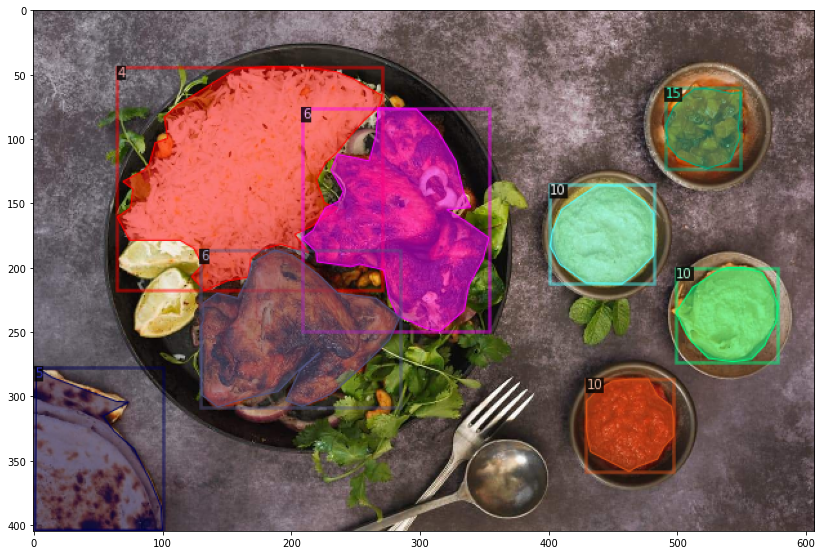

In [ ]:
#visualize img annotations randomly
import matplotlib.pyplot as plt
import random

dataset_dicts = get_dataset_dicts("/content/drive/MyDrive/ashik/train")
for d in random.sample(dataset_dicts, 1):
    img = cv2.imread(d["file_name"])
    v = Visualizer(img[:, :, ::-1], metadata=food_metadata, scale=0.5)
    v = Visualizer(img[:, :, ::-1], scale=0.5)
    v = v.draw_dataset_dict(d)
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()

#Training the Model

In [ ]:
from detectron2.engine import DefaultTrainer
from detectron2.config import get_cfg
#from detectron2.modeling import build_model
#model = build_model(cfg)

In [ ]:
cfg = get_cfg()
cfg.merge_from_file(model_zoo.get_config_file("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml"))
cfg.DATASETS.TRAIN = ("class2_food_indian_train",)
cfg.DATASETS.TEST = ()
cfg.DATALOADER.NUM_WORKERS = 2
cfg.MODEL.WEIGHTS = model_zoo.get_checkpoint_url("COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x.yaml")
cfg.SOLVER.IMS_PER_BATCH = 2
cfg.SOLVER.BASE_LR = 0.00025
cfg.SOLVER.MAX_ITER = 1000
cfg.SOLVER.STEPS = []
cfg.MODEL.ROI_HEADS.NUM_CLASSES = class_num
cfg.OUTPUT_DIR = '/content/drive/MyDrive/ashik/output/'

os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = DefaultTrainer(cfg) 
trainer.resume_or_load(resume=False)


[07/16 16:31:39 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

model_final_f10217.pkl: 178MB [00:01, 94.0MB/s]                           
Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (34, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (34,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (132, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (132,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model du

In [ ]:
trainer.train()

[07/16 16:32:00 d2.engine.train_loop]: Starting training from iteration 0
[07/16 16:32:11 d2.utils.events]:  eta: 0:08:31  iter: 19  total_loss: 4.632  loss_cls: 3.564  loss_box_reg: 0.2868  loss_mask: 0.6916  loss_rpn_cls: 0.01174  loss_rpn_loc: 0.02174  time: 0.5176  data_time: 0.0564  lr: 4.9953e-06  max_mem: 2935M
[07/16 16:32:23 d2.utils.events]:  eta: 0:08:21  iter: 39  total_loss: 4.405  loss_cls: 3.379  loss_box_reg: 0.2773  loss_mask: 0.6898  loss_rpn_cls: 0.01422  loss_rpn_loc: 0.01789  time: 0.5508  data_time: 0.1013  lr: 9.9902e-06  max_mem: 2935M
ERROR [07/16 16:32:29 d2.engine.train_loop]: Exception during training:
Traceback (most recent call last):
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.py", line 138, in train
    self.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/defaults.py", line 441, in run_step
    self._trainer.run_step()
  File "/usr/local/lib/python3.7/dist-packages/detectron2/engine/train_loop.p

FileNotFoundError: ignored

In [ ]:
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

In [ ]:
print(cfg.dump())

CUDNN_BENCHMARK: false
DATALOADER:
  ASPECT_RATIO_GROUPING: true
  FILTER_EMPTY_ANNOTATIONS: true
  NUM_WORKERS: 2
  REPEAT_THRESHOLD: 0.0
  SAMPLER_TRAIN: TrainingSampler
DATASETS:
  PRECOMPUTED_PROPOSAL_TOPK_TEST: 1000
  PRECOMPUTED_PROPOSAL_TOPK_TRAIN: 2000
  PROPOSAL_FILES_TEST: []
  PROPOSAL_FILES_TRAIN: []
  TEST: []
  TRAIN:
  - class11_food_indian_traindata
GLOBAL:
  HACK: 1.0
INPUT:
  CROP:
    ENABLED: false
    SIZE:
    - 0.9
    - 0.9
    TYPE: relative_range
  FORMAT: BGR
  MASK_FORMAT: polygon
  MAX_SIZE_TEST: 1333
  MAX_SIZE_TRAIN: 1333
  MIN_SIZE_TEST: 800
  MIN_SIZE_TRAIN:
  - 640
  - 672
  - 704
  - 736
  - 768
  - 800
  MIN_SIZE_TRAIN_SAMPLING: choice
  RANDOM_FLIP: horizontal
MODEL:
  ANCHOR_GENERATOR:
    ANGLES:
    - - -90
      - 0
      - 90
    ASPECT_RATIOS:
    - - 0.5
      - 1.0
      - 2.0
    NAME: DefaultAnchorGenerator
    OFFSET: 0.0
    SIZES:
    - - 32
    - - 64
    - - 128
    - - 256
    - - 512
  BACKBONE:
    FREEZE_AT: 2
    NAME: build_resn

In [ ]:
type(cfg)

detectron2.config.config.CfgNode

In [ ]:
#from detectron2.modeling import build_model
#model = build_model(cfg)

In [ ]:
#from detectron2.checkpoint import DetectionCheckpointer
#DetectionCheckpointer(model).load('https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl')


#checkpointer = DetectionCheckpointer(model, save_dir="/content/drive/My Drive/Project/output2/")
#checkpointer.save("model_final.pth")

Skip loading parameter 'roi_heads.box_predictor.cls_score.weight' to the model due to incompatible shapes: (81, 1024) in the checkpoint but (3, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.cls_score.bias' to the model due to incompatible shapes: (81,) in the checkpoint but (3,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.weight' to the model due to incompatible shapes: (320, 1024) in the checkpoint but (8, 1024) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.box_predictor.bbox_pred.bias' to the model due to incompatible shapes: (320,) in the checkpoint but (8,) in the model! You might want to double check if this is expected.
Skip loading parameter 'roi_heads.mask_head.predictor.weight' to the model due to incompatible shapes: (80, 256, 1, 1) in the checkpoint but (2, 256, 1, 1) in

In [ ]:
#model_path = "/content/drive/MyDrive/Project/output1/model_999.pth"

In [ ]:
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

#Use model for Inference

In [ ]:
import detectron2
from detectron2.config import get_cfg
import os
from detectron2.engine import DefaultPredictor
import cv2
from detectron2.utils.visualizer import ColorMode
from detectron2.utils.visualizer import Visualizer
import matplotlib.pyplot as plt
from detectron2.data.datasets import register_coco_instances

In [ ]:
cfg.MODEL.WEIGHTS

'https://dl.fbaipublicfiles.com/detectron2/COCO-InstanceSegmentation/mask_rcnn_R_50_FPN_3x/137849600/model_final_f10217.pkl'

In [ ]:
#cfg.MODEL.WEIGHTS = '/content/drive/MyDrive/Project/output1/model_999.pth'

In [ ]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5 
cfg.DATASETS.TEST = ("class11_food_indian_testdata",)
predictor = DefaultPredictor(cfg)

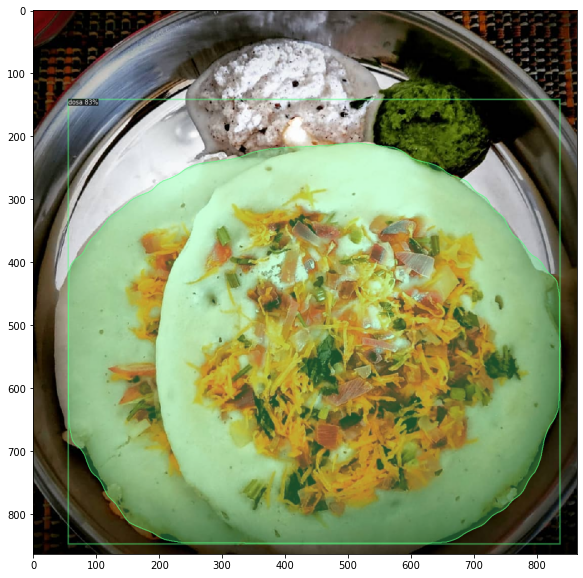

In [ ]:
from detectron2.utils.visualizer import ColorMode
filepath = '/content/drive/MyDrive/Project/testdata/dosatest (16).jpg'
im = cv2.imread(filepath)
outputs = predictor(im)
v = Visualizer(im[:, :, ::-1],
               metadata=food_metadata,
               scale=0.8,
               instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
               )
v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
plt.figure(figsize = (14, 10))
plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
plt.show()

1280 958
567 1080
720 960
1280 720
2176 4608
2592 4608
1280 720
1245 1280
1350 1080
1080 1080
1350 1080
2340 1080
1080 1080
1221 1080
1080 1080
1280 960
1080 1080
2583 4056
1179 1080
2592 4608
4608 2592


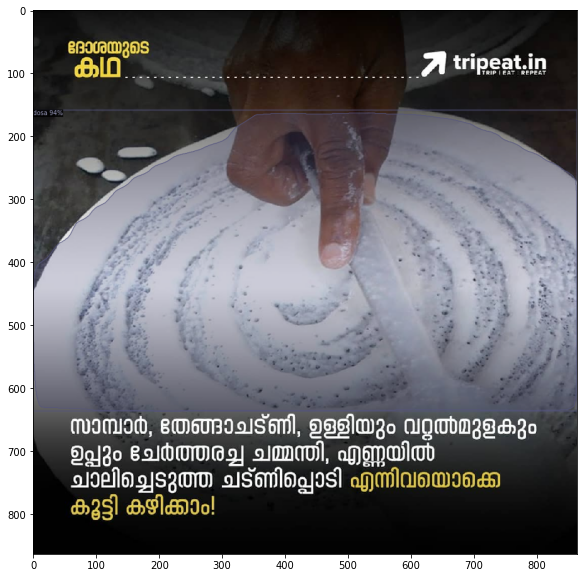

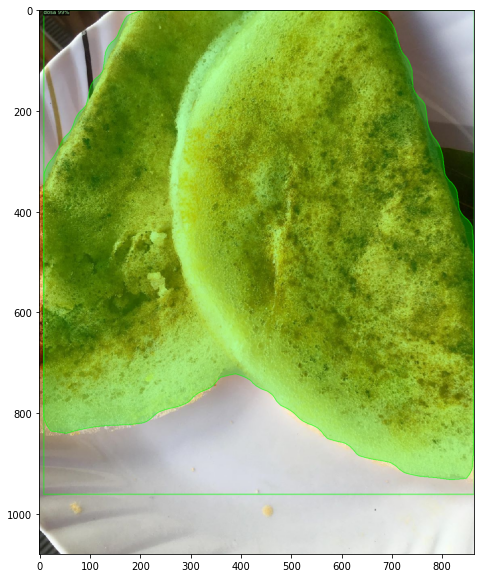

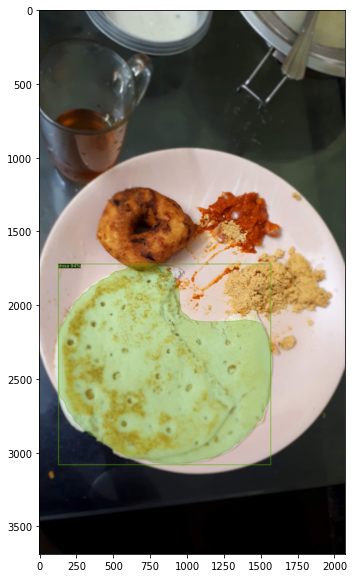

In [ ]:
from detectron2.utils.visualizer import ColorMode
dataset_dicts = get_dataset_dicts('/content/drive/MyDrive/Project/testdata')
for d in random.sample(dataset_dicts, 3):    
    im = cv2.imread(d["file_name"])
    outputs = predictor(im)
    v = Visualizer(im[:, :, ::-1],
                   metadata=food_metadata, 
                   scale=0.8, 
                   instance_mode=ColorMode.IMAGE_BW   # remove the colors of unsegmented pixels
    )
    v = v.draw_instance_predictions(outputs["instances"].to("cpu"))
    plt.figure(figsize = (14, 10))
    plt.imshow(cv2.cvtColor(v.get_image()[:, :, ::-1], cv2.COLOR_BGR2RGB))
    plt.show()